In [ ]:



'''
见下面的jpg文件 
本项目与attention教程中的第一个图类似
b=BATCH_SIZE = 64
d=EMBEDDING_SIZE = 300
h=HIDDEN_SIZE = 512
m_x=max_length_of_x  不同的batch中m_x不同
m_y=max_length_of_y  不同的batch中m_x不同
n=n_layers=3



目标：翻译语句 I see. ==>Je comprends.
原始数据，一行eg:    I see.	   Je comprends.
选择句子短语长度在3-25之间的翻译前后的句子,然后转化为数组  eg====> ['i', 'see', '.']           ['je', 'comprends', '.']
每一句加上结束符号eg=====> ['i', 'see', '.' ,'</s>']               ['je', 'comprends', '.'  ,'</s>']
转化为index   eg====>(tensor([[ 1614, 2251, 257, 3]]),       tensor([[ 1462,5955,257, 3]]))
getBatch后        input补齐长度为max_x得到 (b,m_x,v_x)======(b,m_x,d)  
                  target补齐长度为max_y得到 (b,m_y,v_y)
 
 
 
encode     GRU( input,随机hidden)====>产生最后的hidden层   和enc_output  (d,m_x,2h)                2h是因为双向
decode迭代m_y次， for i in range(m_y):    
    第一次迭代dec_hidden随机初始化，dec_input即context来自于encode的最后hidden层
    后来每一次迭代dec_hidden是上一次迭代产生的新dec_hidden (b,1,2h), 
                dec_input=context来自于      
                attention=encode_output和新dec_hidden进行bnn操作= (b,m_x,2h)  bmm* (b,2h,1) = (b,m_x,1)         #相当于m_x层相似度检查，求内积，然后softmax
                attention =  softmax (attention)      #沿着m_x方向
                context = encode_output和attention进行bnn操作 = (b,m_x,2h)  bmm* (b,m_x,1)  = (b,2h,1)          #相当于m_x层attentin和enc_output乘机和

                dec_output是         cat(新dec_hidden,context) = cat( (b,2h,1),(b,2h,1) ) = (b,4h,1)     
                                    score = (v_y,4h) * (b,4h) = (v_y,b)  
                                     softmaxed = F.log_softmax(score,1)        #沿着v_y方向softmax操作 
                                 #softmaxed:(b,v_y)即为每一次迭代的输出，m_y次迭代即为(m_y,b,v_y) ,然后(m_y,b,v_y)和target做交叉熵得到loss


'''


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter, OrderedDict
import nltk
from copy import deepcopy
import os
import re
import unicodedata
flatten = lambda l: [item for sublist in l for item in sublist]

from torch.nn.utils.rnn import PackedSequence,pack_padded_sequence
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
random.seed(1024)
%matplotlib inline

FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor
ByteTensor = torch.ByteTensor


In [ ]:
def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex=0
    eindex=batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch
        
        
        
        
# It is for Sequence 2 Sequence format  #对于sentence.lenth<maxlenth的句子自动补齐长度
def pad_to_batch(batch, x_to_ix, y_to_ix):
    #按照source的句长从小到大排序
    sorted_batch =  sorted(batch, key=lambda b:b[0].size(1), reverse=True) # sort by len
    x,y = list(zip(*sorted_batch))  #x = [[(2,34,424,12),(34,24)......]]
    max_x = max([s.size(1) for s in x])
    max_y = max([s.size(1) for s in y])  #s.size(1)理解为sentence的长度 ，s.size(1)=1 或者V
    x_p, y_p = [], []
    for i in range(len(batch)):
        if x[i].size(1) < max_x:          #对于sentence.lenth<maxlenth的句子自动补齐长度
            x_p.append(   torch.cat(   [x[i],    Variable(LongTensor([x_to_ix['<PAD>']] * (max_x - x[i].size(1))   )).view(1, -1)], 1  )   )
        else:
            x_p.append(x[i])
        if y[i].size(1) < max_y:
            y_p.append(  torch.cat([y[i], Variable(LongTensor([y_to_ix['<PAD>']] * (max_y - y[i].size(1)))).view(1, -1)], 1))
        else:
            y_p.append(y[i])
        
    input_var = torch.cat(x_p)  #input_var  = [[(2,34,424,12),(34,24,0,0)......]]
    target_var = torch.cat(y_p)
    #input_len表示source   input句子中原有句子的长度
    input_len = [   list(map(lambda s: s ==0, t.data)).count(False)    for t in input_var  ]  #input_len=[4,2....]     (b)
    target_len = [list(map(lambda s: s ==0, t.data)).count(False) for t in target_var]
    
    return input_var, target_var, input_len, target_len



def prepare_sequence(seq, to_index):
    idxs = list(map(lambda w: to_index[w] if to_index.get(w) is not None else to_index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )



# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([,.!?])", r" \1 ", s)
    s = re.sub(r"[^a-zA-Z,.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s


In [3]:
corpus = open(r'C:\workspace\python-work\nlp\NLP-cs224n\NLP-cs224n_ec\notebooks\dataset\translation\eng-fra.txt','r',encoding='utf-8').readlines()
print(len(corpus))
corpus = corpus[:30000]  # for practice
print(len(corpus))
for i in range(22):
    print(corpus[i].strip())
    



170190
30000
Go.	Va !
Hi.	Salut !
Hi.	Salut.
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !
Wait!	Attends !
Wait!	Attendez !
Go on.	Poursuis.
Go on.	Continuez.
Go on.	Poursuivez.
Hello!	Bonjour !
Hello!	Salut !
I see.	Je comprends.
I try.	J'essaye.


In [4]:
%%time

X_r,y_r=[],[]
     
MIN_LENGTH = 3
MAX_LENGTH = 25
tmp=0

#选择句子短语长度在3——25之间的翻译前后的句子,然后转化为数组    #   "I see." ===>   ['i', 'see', '.'] 
for parallel in corpus: 
    tmp+=1
    so,ta = parallel[:-1].split('\t')
    if so.strip() == "" or ta.strip() == "": 
        continue
    
    normalized_so = normalize_string(so).split()       #   "I see." ===>   ['i', 'see', '.'] 
    normalized_ta = normalize_string(ta).split()       #    "Je comprends. "  =====>  ['je', 'comprends', '.']
    
    
    if (tmp==21):
        print(so,'===>',normalized_so,'\n',ta,'====>',normalized_ta)
    if (tmp==22):
        print(so,'===>',normalized_so,'\n',ta,'====>',normalized_ta)
        
    if len(normalized_so) >= MIN_LENGTH and len(normalized_so) <= MAX_LENGTH and len(normalized_ta) >= MIN_LENGTH and len(normalized_ta) <= MAX_LENGTH:
        X_r.append(normalized_so)
        y_r.append(normalized_ta)
    
print(X_r[:10])
print(y_r[:10])

print(len(X_r), len(y_r))
print(X_r[0], y_r[0])

I see. ===> ['i', 'see', '.'] 
 Je comprends. ====> ['je', 'comprends', '.']
I try. ===> ['i', 'try', '.'] 
 J'essaye. ====> ['j', 'essaye', '.']


[['i', 'see', '.'], ['i', 'try', '.'], ['i', 'won', '!'], ['i', 'won', '!'], ['i', 'won', '.'], ['oh', 'no', '!'], ['get', 'up', '.'], ['go', 'now', '.'], ['go', 'now', '.'], ['go', 'now', '.']]
[['je', 'comprends', '.'], ['j', 'essaye', '.'], ['j', 'ai', 'gagne', '!'], ['je', 'l', 'ai', 'emporte', '!'], ['j', 'ai', 'gagne', '.'], ['oh', 'non', '!'], ['leve', 'toi', '.'], ['va', ',', 'maintenant', '.'], ['allez', 'y', 'maintenant', '.'], ['vas', 'y', 'maintenant', '.']]
29794 29794
['i', 'see', '.'] ['je', 'comprends', '.']
Wall time: 1.15 s


In [5]:
source_vocab = list(set(flatten(X_r)))
target_vocab = list(set(flatten(y_r)))
print(len(source_vocab), len(target_vocab))

4401 7589


In [6]:
source2index = {'<PAD>': 0, '<UNK>': 1, '<s>': 2, '</s>': 3}
for vo in source_vocab:
    if source2index.get(vo) is None:
        source2index[vo] = len(source2index)
index2source = {v:k for k, v in source2index.items()}



target2index = {'<PAD>': 0, '<UNK>': 1, '<s>': 2, '</s>': 3}
for vo in target_vocab:
    if target2index.get(vo) is None:
        target2index[vo] = len(target2index)
index2target = {v:k for k, v in target2index.items()}



In [7]:
%%time
X_p, y_p = [], []

for so, ta in zip(X_r, y_r):
    X_p.append(prepare_sequence(so + ['</s>'], source2index).view(1, -1))
    y_p.append(prepare_sequence(ta + ['</s>'], target2index).view(1, -1))
    
train_data = list(zip(X_p, y_p))

for i in range(10):
    print(train_data[i])
    
    
'''
(tensor([[ 1614, 2251, 257, 3]]), tensor([[ 1462,5955,5735,3]]))         
上面解释  word2index  ['i', 'see', '.',  '</s>'] ======>[[ 1614, 2251, 257, 3]]       ['je', 'comprends', '.','</s>']=====>[[ 1462,  5955, 5735, 3]]
'''

(tensor([[ 4076,  3067,  1074,     3]]), tensor([[ 6171,  1531,  4166,     3]]))
(tensor([[ 4076,  2437,  1074,     3]]), tensor([[ 3087,  5430,  4166,     3]]))
(tensor([[ 4076,  2007,   416,     3]]), tensor([[ 3087,  2522,  5098,  3887,     3]]))
(tensor([[ 4076,  2007,   416,     3]]), tensor([[ 6171,  2338,  2522,  3513,  3887,     3]]))
(tensor([[ 4076,  2007,  1074,     3]]), tensor([[ 3087,  2522,  5098,  4166,     3]]))
(tensor([[ 4009,  2840,   416,     3]]), tensor([[ 1694,  6879,  3887,     3]]))
(tensor([[  584,  1632,  1074,     3]]), tensor([[ 3685,  5446,  4166,     3]]))
(tensor([[  902,  1342,  1074,     3]]), tensor([[ 4831,  3621,  4256,  4166,     3]]))
(tensor([[  902,  1342,  1074,     3]]), tensor([[ 7277,  4720,  4256,  4166,     3]]))
(tensor([[  902,  1342,  1074,     3]]), tensor([[ 6614,  4720,  4256,  4166,     3]]))
Wall time: 591 ms


"\n(tensor([[ 1614, 2251, 257, 3]]), tensor([[ 1462,5955,5735,3]]))         \n上面解释  word2index  ['i', 'see', '.',  '</s>'] ======>[[ 1614, 2251, 257, 3]]       ['je', 'comprends', '.','</s>']=====>[[ 1462,  5955, 5735, 3]]\n"

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size,hidden_size, n_layers=1,bidirec=False):      #n=nlayers=3
        super(Encoder, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, embedding_size) #(v,d)
        
        if bidirec:
            self.n_direction = 2 
            self.gru = nn.GRU(embedding_size, hidden_size, n_layers, batch_first=True, bidirectional=True)  
        else:
            self.n_direction = 1
            self.gru = nn.GRU(embedding_size, hidden_size, n_layers, batch_first=True)
    
    def init_hidden(self, inputs):
        #inputs.size(0)  =  B    (6,B,H)
        hidden = Variable(torch.zeros(self.n_layers * self.n_direction, inputs.size(0), self.hidden_size))      #(2*n,b,h)
        return hidden
    
    def init_weight(self):
        self.embedding.weight = nn.init.xavier_uniform(self.embedding.weight)
        self.gru.weight_hh_l0 = nn.init.xavier_uniform(self.gru.weight_hh_l0)
        self.gru.weight_ih_l0 = nn.init.xavier_uniform(self.gru.weight_ih_l0)
    
    def forward(self, inputs, input_lengths):         # (b,m_x,v), (b) 
        """
        input_lengths : real lengths of input batch (list)
        """
        hidden = self.init_hidden(inputs)  #(2*n,b,h)=(6,b,h)
        
        
        embedded = self.embedding(inputs)  # (d,v) * (b,m_x,v)=(b,m_x,d)
        
        packed = pack_padded_sequence(embedded, input_lengths, batch_first=True)
        #outputs:(m_x,2*h,b)    hidden:(6,h,b)
        outputs, hidden = self.gru(packed, hidden)       #gru( (b,m_x,d),(6,b,h)  )
      
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True) # unpack (back to padded)
                
        if self.n_layers > 1:
            if self.n_direction == 2:
                hidden = hidden[-2:]
            else:
                hidden = hidden[-1]
        
        return outputs, torch.cat([h for h in hidden], 1).unsqueeze(1)      #outputs:(m_x,2*h,b)    hidden:(2h,b) 
    
   
   
    
class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, n_layers=1, dropout_p=0.1): # Decoder(v_y, d,2h)
        
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        # Define the layers
        self.embedding = nn.Embedding(input_size, embedding_size)  #(v_y,d)
        self.dropout = nn.Dropout(dropout_p)
        
        self.gru = nn.GRU(embedding_size + hidden_size, hidden_size, n_layers, batch_first=True)   #(d+2h,2h_
        self.linear = nn.Linear(hidden_size * 2, input_size) #(4h,v_y)
        self.attn = nn.Linear(self.hidden_size, self.hidden_size) # Attention  #(2h,2h)
    
    def init_hidden(self,inputs):
        hidden = Variable(torch.zeros(self.n_layers, inputs.size(0), self.hidden_size))  #(n,v_y,2h)=(1,v_y,2h)
        return  hidden
    
    
    def init_weight(self):
        self.embedding.weight = nn.init.xavier_uniform(self.embedding.weight)
        self.gru.weight_hh_l0 = nn.init.xavier_uniform(self.gru.weight_hh_l0)
        self.gru.weight_ih_l0 = nn.init.xavier_uniform(self.gru.weight_ih_l0)
        self.linear.weight = nn.init.xavier_uniform(self.linear.weight)
        self.attn.weight = nn.init.xavier_uniform(self.attn.weight)
#         self.attn.bias.data.fill_(0)
    
    def Attention(self, hidden, encoder_outputs, encoder_maskings):      #self.Attentin( (1,b,2h),(b,m_x,2h) ,none  )
        """
        hidden : (1,b,2h)
        encoder_outputs :(b,m_x,2h)
        encoder_maskings : B,T # ByteTensor
        """
        hidden = hidden[0].unsqueeze(2)  # (1,b,2h) ->  (b,2h) ---->(b,2h,1)
        batch_size = encoder_outputs.size(0) # b
        max_len = encoder_outputs.size(1) # m_x
        energies = self.attn(encoder_outputs.contiguous().view(batch_size * max_len, -1)) # (b,m_x,2h) ===>(b*m_x,2h)    (2h,2h)*(b*m_x,2h)=(b*m_x,2h)
        energies = energies.view(batch_size,max_len, -1) #(b*m_x,2h)===>(b,m_x,2h)
        
        #求attention  内积操作  得到attention:(b,m_x)    然后softmax
        attn_energies = energies.bmm(hidden).squeeze(2) # B,T,D * B,D,1 --> B,T           (b,m_x,2h) bmm  (b,2h,1) =====>(b,m_x,1)=====>(b,m_x)
        alpha = F.softmax(attn_energies,1) # (b,m_x)
        alpha = alpha.unsqueeze(1) # (b,1，m_x)
        
        
        #求context    endoder_output 和 attention 运行bmm（batch  matrix multip)操作得到context= (b,1,2h) 
#                                                      <=============>  等效于每一层output和其attention的乘积，然后相加
        context = alpha.bmm(encoder_outputs)  #(b,1，m_x)  * (b,m_x,2h) ---->(b,1,2h) 
        
        return context, alpha               #alpha相当于softmax之后的attention
    
    # forward(  (b,1),(b,1,2h),max_y,(m_x,2*h,b) , (b,max_x)  )
    def forward(self, inputs, context, max_length, encoder_outputs, encoder_maskings=None, is_training=False):
        """
        inputs : B,1 (LongTensor, START SYMBOL)
        context : B,1,2h (FloatTensor, Last encoder hidden state)
        max_length : int, max length to decode # for batch
        encoder_outputs : b,max_x,2h
        encoder_maskings : B,max_x # ByteTensor
        is_training : bool, this is because adapt dropout only training step.
        """
        # Get the embedding of the current input word
        embedded = self.embedding(inputs)      # (v_y,d)*(b,1)====>(v_y,d)*(b,v_y)=(b,1,d)
        
        hidden = self.init_hidden(inputs)       #(1,v_y,2h)*(b,1)=======>(1,v_y,2h)*(b,v_y)=(1,b,2h)
        
        if is_training:
            embedded = self.dropout(embedded)
        
        decode = []
        # Apply GRU to the output so far
        for i in range(max_length): #m_y
            # tmp=torch.cat((embedded, context),2)    #(b,1,d)  cat  (b,1,2h) ===>(b,1,d+2h)
            
            #hidden:(1,b,2h)
            _, hidden = self.gru(torch.cat((embedded, context), 2), hidden)     #self.gru(  (b,1,d+2h) ,(1,b,2h) )
            
            concated = torch.cat((hidden, context.transpose(0, 1)), 2) # (1,b,4h)
            score = self.linear(concated.squeeze(0))                   # (1,b,4h)*(4h,v_y)= (b,v_y)
            softmaxed = F.log_softmax(score,1)        #沿着v_y方向softmax操作      (b,v_y)
        
            #这是用于计算lossfunction的预测数据， softmaxed:(b,v_y)
            decode.append(softmaxed)
            
            decoded = softmaxed.max(1)[1]       #decoded:(64)=(b)
            embedded = self.embedding(decoded).unsqueeze(1) #(d,v_y) * (b) ==>(b,1,d)
            if is_training:
                embedded = self.dropout(embedded)
            
            # compute next context vector using attention   
            #contex：(b,1,2h)           #alpha相当于softmax之后的attention ：(b,1，m_x)
            context, alpha = self.Attention(hidden, encoder_outputs, encoder_maskings)     #self.Attentin( (1,b,2h),(m_x,2*h,b) ,none  )
            
        #  column-wise concat, reshape!!
        #decode是数组，长度为max_y,每个元素是softmaxed :(b,v_y)          max_length=max_y
        scores = torch.cat(decode, 1)
    
        return scores.view(inputs.size(0) * max_length, -1)    #(b*max_y,v_y)

    
    #测试的时候用
    #context为decode最后hidden:(2h,b)    #encoder_outputs:(m_x,2*h,b)           2h是因为双向 (b,2,h)===>(b,2h)
    def decode(self, context, encoder_outputs):
        start_decode = Variable(LongTensor([[target2index['<s>']] * 1])).transpose(0, 1) #(b,1)  此处b=1
        embedded = self.embedding(start_decode)    #   (v_y,d)*(b,1)====>(v_y,d)*(b,v_y)=(b,1,d)
        hidden = self.init_hidden(start_decode)     #(1,v_y,2h)*(b,1)=======>(1,v_y,2h)*(b,v_y)=(1,b,2h)
        
        decodes = []
        attentions = []
        decoded = embedded
        while decoded.data.tolist()[0] != target2index['</s>']: # until </s>    相当于 for i in range(max_y):,知道预测到结束符
             # tmp=torch.cat((embedded, context),2)    #(b,1,d)  cat  (b,1,2h) ===>(b,1,d+2h)
            #hidden:(1,b,2h)
            _, hidden = self.gru(torch.cat((embedded, context), 2), hidden)   #self.gru(  (b,1,d+2h) ,(1,b,2h) )
             
            concated = torch.cat((hidden, context.transpose(0, 1)), 2)  # (1,b,4h)
            score = self.linear(concated.squeeze(0))               # (1,b,4h)*(4h,v_y)= (b,v_y)
             
            
            softmaxed = F.log_softmax(score,1)                 #沿着v_y方向softmax操作      (b,v_y)
            #decodes这是用于记录预测结果， softmaxed:(b,v_y)
            decodes.append(softmaxed)
              
            decoded = softmaxed.max(1)[1]      #decoded:(64)=(b)
            embedded = self.embedding(decoded).unsqueeze(1) #(d,v_y) * (b) ==>(b,1,d)
             
             # compute next context vector using attention   
            #contex：(b,1,2h)           #alpha相当于softmax之后的attention ：(b,1，m_x)
            context, alpha = self.Attention(hidden, encoder_outputs,None)        #self.Attentin( (1,b,2h),(m_x,2*h,b) ,none  )
            #alpha相当于softmax之后的attention ：(b,1，m_x)
            attentions.append(alpha.squeeze(1))
        
        return torch.cat(decodes).max(1)[1], torch.cat(attentions)

In [9]:
EPOCH = 2
BATCH_SIZE = 64
EMBEDDING_SIZE = 300
HIDDEN_SIZE = 512
LR = 0.001
DECODER_LEARNING_RATIO = 5.0
RESCHEDULED = False

encoder = Encoder(len(source2index), EMBEDDING_SIZE, HIDDEN_SIZE, 3, True) #bidirectional
decoder = Decoder(len(target2index), EMBEDDING_SIZE, HIDDEN_SIZE * 2)
encoder.init_weight()
decoder.init_weight()



loss_function = nn.CrossEntropyLoss(ignore_index=0)
enc_optimizer = optim.Adam(encoder.parameters(), lr=LR)
dec_optimizer = optim.Adam(decoder.parameters(), lr=LR * DECODER_LEARNING_RATIO)



for epoch in range(EPOCH):
    losses=[]
    for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)):
        
    #input_var  = [[(2,34,424,12),(34,24,0,0)......]]  长度不够的0自动补齐       #input_len表示source  input句子中原有句子的长度 eg: input_len=[4,2....]  (b))
        inputs, targets, input_lengths, target_lengths = pad_to_batch(batch, source2index, target2index)
        # inputs.size()=(b,max_x)=(64,8)            targets.size()=(b,max_y)=(64,15)    
        #input_masks表示inputs数组中每一个元素是否是自动补齐的<P>   (b,max_x)=(64,8)  每一个元素是一个二元组（data，bool）
        input_masks = torch.cat([Variable(ByteTensor(tuple(map(lambda s: s ==0, t.data)))) for t in inputs]).view(inputs.size(0), -1)
        
        #start_decode:(b,1)
        start_decode = Variable(LongTensor([[target2index['<s>']] * targets.size(0)])).transpose(0, 1)   #targets.size(0)=b
    
        encoder.zero_grad()
        decoder.zero_grad()
         #output:(m_x,2*h,b)    hidden_c:(2h,b) 
        output, hidden_c = encoder(inputs, input_lengths)         #encoder(   (b,m_x,v),(b) )
        
        #preds:(b*max_y,v_y)  是softmax之后预测的值
        preds = decoder(start_decode, hidden_c, targets.size(1), output, input_masks, True)#decoder( (b,1),(2h,b),max_y,(m_x,2*h,b) , (b,max_x)  )
        #target:(b,max_y)             
        loss = loss_function(preds, targets.view(-1))
        losses.append(loss.data.tolist() )
        loss.backward()
        torch.nn.utils.clip_grad_norm(encoder.parameters(), 50.0) # gradient clipping
        torch.nn.utils.clip_grad_norm(decoder.parameters(), 50.0) # gradient clipping
        enc_optimizer.step()
        dec_optimizer.step()

        if i % 10==0:
            print("[%02d/%d] [%03d/%d] mean_loss : %0.2f" %(epoch, EPOCH, i, len(train_data)//BATCH_SIZE, np.mean(losses)))
            losses=[]

    # You can use http://pytorch.org/docs/master/optim.html#how-to-adjust-learning-rate
    if RESCHEDULED == False and epoch  == EPOCH//2:
        LR *= 0.01
        enc_optimizer = optim.Adam(encoder.parameters(), lr=LR)
        dec_optimizer = optim.Adam(decoder.parameters(), lr=LR * DECODER_LEARNING_RATIO)
        RESCHEDULED = True



C:\software_installed_cs\Anaconda3\envs\pytorch0.4\lib\site-packages\ipykernel_launcher.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\software_installed_cs\Anaconda3\envs\pytorch0.4\lib\site-packages\ipykernel_launcher.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\software_installed_cs\Anaconda3\envs\pytorch0.4\lib\site-packages\ipykernel_launcher.py:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\software_installed_cs\Anaconda3\envs\pytorch0.4\lib\site-packages\ipykernel_launcher.py:76: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\software_installed_cs\Anaconda3\envs\pytorch0.4\lib\site-packages\ipykernel_launcher.py:77: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\software_installed_cs\Anaconda3\envs\pytorch0.4\lib\site-packages\i

C:\software_installed_cs\Anaconda3\envs\pytorch0.4\lib\site-packages\ipykernel_launcher.py:80: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


C:\software_installed_cs\Anaconda3\envs\pytorch0.4\lib\site-packages\ipykernel_launcher.py:46: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
C:\software_installed_cs\Anaconda3\envs\pytorch0.4\lib\site-packages\ipykernel_launcher.py:47: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


[00/2] [000/465] mean_loss : 8.93


[00/2] [010/465] mean_loss : 6.46


[00/2] [020/465] mean_loss : 5.18


[00/2] [030/465] mean_loss : 4.93


[00/2] [040/465] mean_loss : 4.78


[00/2] [050/465] mean_loss : 4.50


[00/2] [060/465] mean_loss : 4.44


[00/2] [070/465] mean_loss : 4.34


[00/2] [080/465] mean_loss : 4.34


[00/2] [090/465] mean_loss : 4.14


[00/2] [100/465] mean_loss : 4.06


[00/2] [110/465] mean_loss : 4.03


[00/2] [120/465] mean_loss : 3.95


[00/2] [130/465] mean_loss : 3.91


[00/2] [140/465] mean_loss : 3.95


[00/2] [150/465] mean_loss : 3.88


[00/2] [160/465] mean_loss : 3.82


[00/2] [170/465] mean_loss : 3.77


[00/2] [180/465] mean_loss : 3.80


[00/2] [190/465] mean_loss : 3.86


[00/2] [200/465] mean_loss : 3.80


[00/2] [210/465] mean_loss : 3.66


[00/2] [220/465] mean_loss : 3.70


[00/2] [230/465] mean_loss : 3.58


[00/2] [240/465] mean_loss : 3.67


[00/2] [250/465] mean_loss : 3.60


[00/2] [260/465] mean_loss : 3.71


[00/2] [270/465] mean_loss : 3.63


[00/2] [280/465] mean_loss : 3.63


[00/2] [290/465] mean_loss : 3.58


[00/2] [300/465] mean_loss : 3.54


[00/2] [310/465] mean_loss : 3.49


[00/2] [320/465] mean_loss : 3.43


[00/2] [330/465] mean_loss : 3.58


[00/2] [340/465] mean_loss : 3.56


[00/2] [350/465] mean_loss : 3.36


[00/2] [360/465] mean_loss : 3.43


[00/2] [370/465] mean_loss : 3.36


[00/2] [380/465] mean_loss : 3.29


[00/2] [390/465] mean_loss : 3.33


[00/2] [400/465] mean_loss : 3.29


[00/2] [410/465] mean_loss : 3.25


[00/2] [420/465] mean_loss : 3.27


[00/2] [430/465] mean_loss : 3.24


[00/2] [440/465] mean_loss : 3.15


[00/2] [450/465] mean_loss : 3.23


[00/2] [460/465] mean_loss : 3.20


[01/2] [000/465] mean_loss : 2.97


[01/2] [010/465] mean_loss : 2.96


[01/2] [020/465] mean_loss : 2.88


[01/2] [030/465] mean_loss : 2.90


[01/2] [040/465] mean_loss : 2.92


[01/2] [050/465] mean_loss : 2.85


[01/2] [060/465] mean_loss : 2.85


[01/2] [070/465] mean_loss : 2.86


[01/2] [080/465] mean_loss : 2.79


[01/2] [090/465] mean_loss : 2.70


[01/2] [100/465] mean_loss : 2.73


[01/2] [110/465] mean_loss : 2.82


[01/2] [120/465] mean_loss : 2.78


[01/2] [130/465] mean_loss : 2.80


[01/2] [140/465] mean_loss : 2.74


[01/2] [150/465] mean_loss : 2.74


[01/2] [160/465] mean_loss : 2.65


[01/2] [170/465] mean_loss : 2.61


[01/2] [180/465] mean_loss : 2.76


[01/2] [190/465] mean_loss : 2.69


[01/2] [200/465] mean_loss : 2.70


[01/2] [210/465] mean_loss : 2.71


[01/2] [220/465] mean_loss : 2.64


[01/2] [230/465] mean_loss : 2.72


[01/2] [240/465] mean_loss : 2.75


[01/2] [250/465] mean_loss : 2.66


[01/2] [260/465] mean_loss : 2.60


[01/2] [270/465] mean_loss : 2.58


[01/2] [280/465] mean_loss : 2.50


[01/2] [290/465] mean_loss : 2.49


[01/2] [300/465] mean_loss : 2.51


[01/2] [310/465] mean_loss : 2.54


[01/2] [320/465] mean_loss : 2.51


[01/2] [330/465] mean_loss : 2.43


[01/2] [340/465] mean_loss : 2.53


[01/2] [350/465] mean_loss : 2.45


[01/2] [360/465] mean_loss : 2.47


[01/2] [370/465] mean_loss : 2.59


[01/2] [380/465] mean_loss : 2.53


[01/2] [390/465] mean_loss : 2.51


[01/2] [400/465] mean_loss : 2.43


[01/2] [410/465] mean_loss : 2.47


[01/2] [420/465] mean_loss : 2.37


[01/2] [430/465] mean_loss : 2.44


[01/2] [440/465] mean_loss : 2.52


[01/2] [450/465] mean_loss : 2.47


[01/2] [460/465] mean_loss : 2.37


In [10]:

def show_attention(input_words, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_words, rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     show_plot_visdom()
    plt.show()
    plt.close()

Source :  i m tired of boston .
Truth :  je suis fatigue de boston .
Prediction :  je suis fatiguee de boston . 



input= ['i', 'm', 'tired', 'of', 'boston', '.', '</s>']
truth= tensor([[ 6171,    74,  1198,  2653,    50,  4166,     3]])
prediction= ['je', 'suis', 'fatiguee', 'de', 'boston', '.', '</s>']
attention= torch.Size([7, 7]) 


 tensor([[ 9.9977e-01,  2.2760e-04,  4.4660e-22,  5.0131e-21,  7.3736e-23,
          1.0741e-19,  3.7500e-23],
        [ 3.0157e-07,  1.0000e+00,  1.4388e-07,  1.1932e-15,  4.9877e-23,
          2.9466e-22,  5.1918e-23],
        [ 4.1070e-18,  4.9535e-21,  1.1506e-10,  9.9972e-01,  2.7535e-04,
          1.2978e-22,  4.0850e-13],
        [ 7.3707e-26,  5.8070e-32,  2.4948e-20,  8.4258e-09,  1.0000e+00,
          1.8944e-28,  4.9664e-25],
        [ 1.1799e-33,  7.2128e-37,  2.9370e-20,  1.7539e-12,  1.0000e+00,
          3.8148e-28,  5.9441e-28],
        [ 1.5854e-32,  3.0696e-35,  6.0884e-22,  1.2827e-16,  1.0000e+00,
          2.5257e-24,  7.3656e-27],

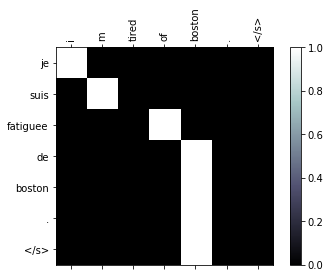

In [23]:
test = random.choice(train_data)
input_ = test[0]
truth = test[1]

output, hidden = encoder(input_, [input_.size(1)])
pred, attn = decoder.decode(hidden, output)

input_ = [index2source[i] for i in input_.data.tolist()[0]]
pred = [index2target[i] for i in pred.data.tolist()]


print('Source : ',' '.join([i for i in input_ if i not in ['</s>']]))
print('Truth : ',' '.join([index2target[i] for i in truth.data.tolist()[0] if i not in [2, 3]]))
print('Prediction : ',' '.join([i for i in pred if i not in ['</s>']]),"\n\n\n")



print("input=",input_)
print("truth=",truth)
print("prediction=",pred)
print("attention=",attn.data.size(),'\n\n\n',attn.data)

show_attention(input_, pred, attn.data)